In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [4]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

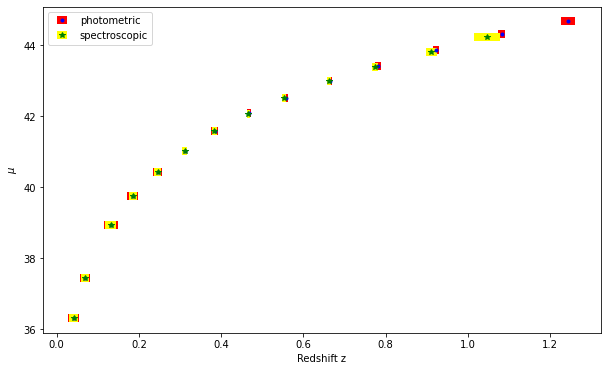

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [6]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [7]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [8]:
len(dfp)

14

In [9]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [10]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [11]:
np.shape(noise1y)

(14, 2)

In [12]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [13]:
np.shape(y), np.shape(z)

((42, 2), (42,))

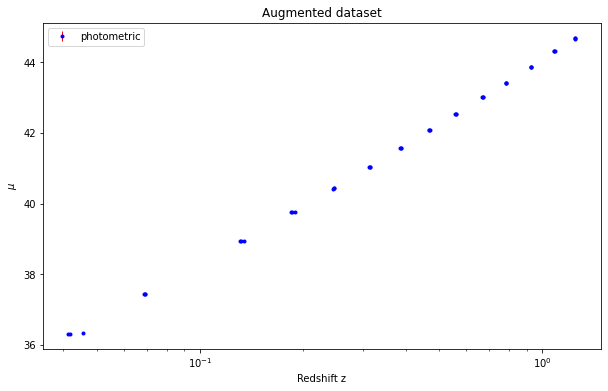

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [15]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [16]:
split = 0.9
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [18]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((35,), (37,), (9, 1), (9, 1))

In [19]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 1
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,100,100, 100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_2 (MCDropout)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_3 (MCDropout)     (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [27]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2000
19/19 [==============================] - 1s 10ms/step - loss: 18.5447 - val_loss: 11.4670
Epoch 2/2000
19/19 [==============================] - 0s 3ms/step - loss: 17.7577 - val_loss: 12.9934
Epoch 3/2000
19/19 [==============================] - 0s 3ms/step - loss: 16.1956 - val_loss: 14.9313
Epoch 4/2000
19/19 [==============================] - 0s 3ms/step - loss: 12.5664 - val_loss: 5.3598
Epoch 5/2000
19/19 [==============================] - 0s 3ms/step - loss: 12.7215 - val_loss: 14.1986
Epoch 6/2000
19/19 [==============================] - 0s 3ms/step - loss: 12.0075 - val_loss: 9.7667
Epoch 7/2000
19/19 [==============================] - 0s 3ms/step - loss: 13.2793 - val_loss: 20.8342
Epoch 8/2000
19/19 [==============================] - 0s 3ms/step - loss: 17.2464 - val_loss: 9.3436
Epoch 9/2000
19/19 [==============================] - 0s 3ms/step - loss: 14.8879 - val_loss: 9.6180
Epoch 10/2000
19/19 [==============================] - 0s 3ms/step - loss: 14.7760 - 

Epoch 81/2000
19/19 [==============================] - 0s 3ms/step - loss: 12.1491 - val_loss: 6.6377
Epoch 82/2000
19/19 [==============================] - 0s 3ms/step - loss: 10.2313 - val_loss: 3.1441
Epoch 83/2000
19/19 [==============================] - 0s 3ms/step - loss: 14.7576 - val_loss: 9.3293
Epoch 84/2000
19/19 [==============================] - 0s 3ms/step - loss: 14.6603 - val_loss: 9.5702
Epoch 85/2000
19/19 [==============================] - 0s 3ms/step - loss: 8.0447 - val_loss: 5.5537
Epoch 86/2000
19/19 [==============================] - 0s 3ms/step - loss: 9.9623 - val_loss: 11.1123
Epoch 87/2000
19/19 [==============================] - 0s 3ms/step - loss: 13.0114 - val_loss: 20.6456
Epoch 88/2000
19/19 [==============================] - 0s 3ms/step - loss: 16.4603 - val_loss: 9.6807
Epoch 89/2000
19/19 [==============================] - 0s 3ms/step - loss: 13.6169 - val_loss: 5.5449
Epoch 90/2000
19/19 [==============================] - 0s 3ms/step - loss: 13.5483

19/19 [==============================] - 0s 3ms/step - loss: 10.0913 - val_loss: 6.1124
Epoch 161/2000
19/19 [==============================] - 0s 3ms/step - loss: 17.5399 - val_loss: 10.2453
Epoch 162/2000
19/19 [==============================] - 0s 3ms/step - loss: 16.2828 - val_loss: 16.5627
Epoch 163/2000
19/19 [==============================] - 0s 3ms/step - loss: 11.7036 - val_loss: 7.8350
Epoch 164/2000
19/19 [==============================] - 0s 3ms/step - loss: 13.8591 - val_loss: 19.2931
Epoch 165/2000
19/19 [==============================] - 0s 3ms/step - loss: 16.8629 - val_loss: 16.5023
Epoch 166/2000
19/19 [==============================] - 0s 3ms/step - loss: 22.2708 - val_loss: 2.5662
Epoch 167/2000
19/19 [==============================] - 0s 3ms/step - loss: 13.9611 - val_loss: 18.0788
Epoch 168/2000
19/19 [==============================] - 0s 3ms/step - loss: 14.1681 - val_loss: 9.5328
Epoch 169/2000
19/19 [==============================] - 0s 3ms/step - loss: 21.8095

In [28]:
model_train.history['val_loss'][-1]

7.479498386383057

In [29]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 2000 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 2ms/step


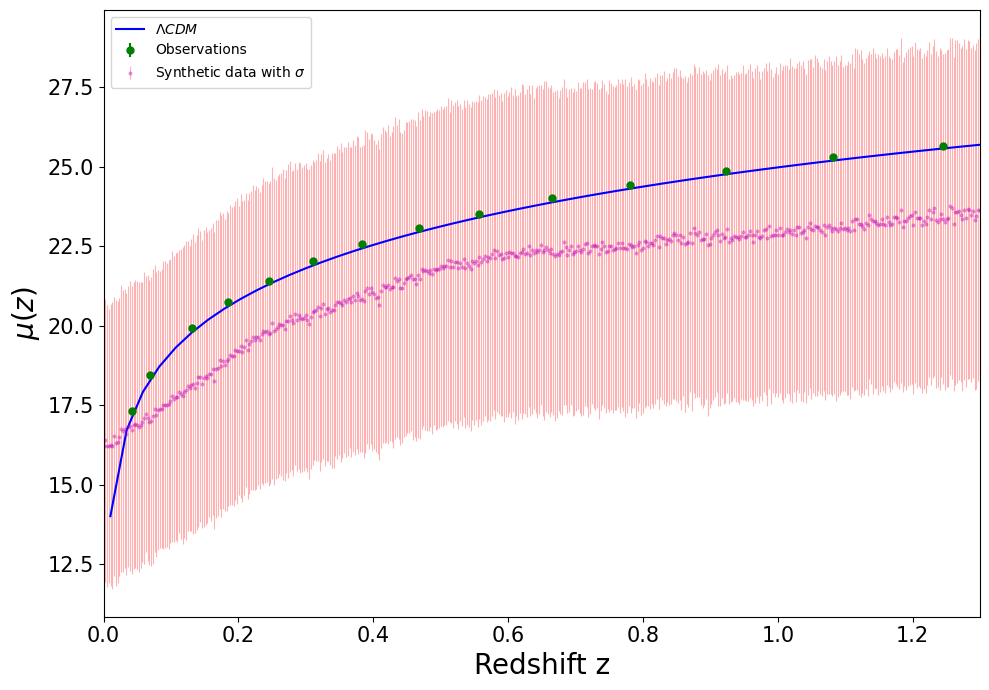

In [30]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

(0.0, 200.0)

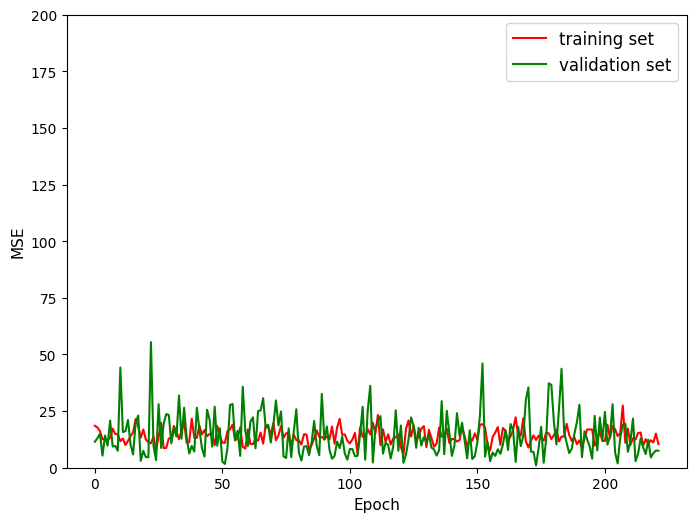

In [31]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)